![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

**Diccionario de datos**

Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv
	
	- instant: record index
	- dteday : date
	- season : season (1:springer, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn import metrics
plt.style.use('fivethirtyeight')

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

orig_data = bikes

### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

**Criterio de evaluación:**
Escribe las inferencias sobre el comportamiento de las dos variables ("hour" y "season"). Hace uso de estadística descriptiva como por ejemplo máximo, mínimo y percentiles al hacer las inferencias. [5 puntos]

In [4]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

In [5]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

In [6]:
# Celda 1.3
bikes['season'].value_counts()

4    2734
2    2733
3    2733
1    2686
Name: season, dtype: int64

In [7]:
# Celda 1.4
bikes['hour'].value_counts()

12    456
13    456
22    456
21    456
20    456
19    456
18    456
17    456
16    456
15    456
14    456
23    456
11    455
10    455
9     455
8     455
7     455
6     455
0     455
1     454
5     452
2     448
4     442
3     433
Name: hour, dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


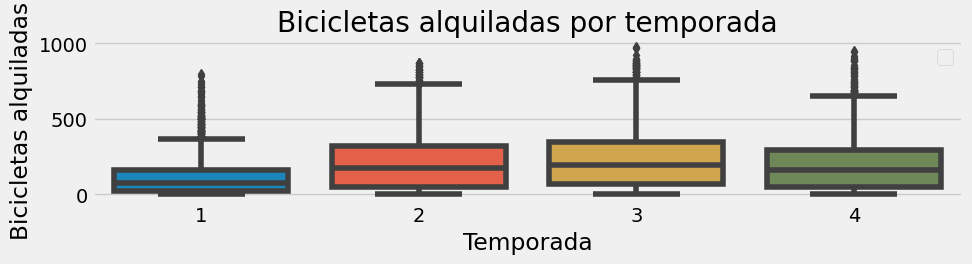

In [8]:
# Celda 1.5

fig = plt.figure(figsize=(10,2))
ax = sns.boxplot(data=bikes, x="season", y='total')
ax.set_xlabel('Temporada')
ax.set_ylabel('Bicicletas alquiladas')
ax.set_title('Bicicletas alquiladas por temporada')
ax.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


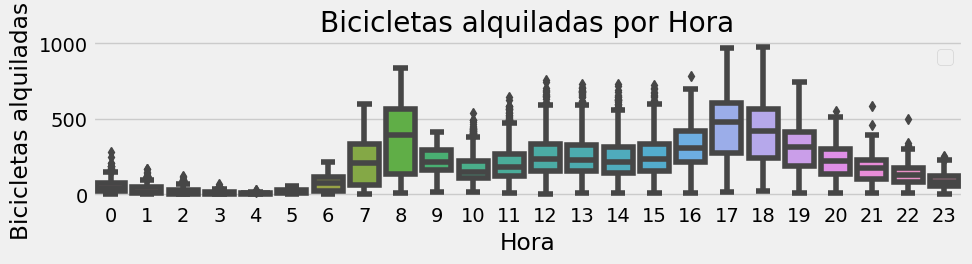

In [9]:
# Celda 1.6

fig = plt.figure(figsize=(10,2))
ax = sns.boxplot(data=bikes, x="hour", y='total')
ax.set_xlabel('Hora')
ax.set_ylabel('Bicicletas alquiladas')
ax.set_title('Bicicletas alquiladas por Hora')
ax.legend()
plt.show()

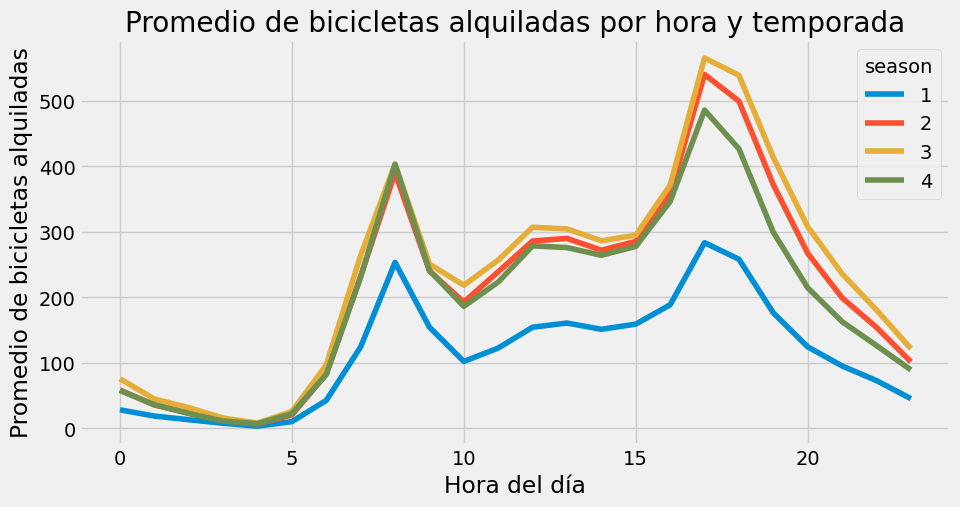

In [10]:
# Celda 1.7

import matplotlib.pyplot as plt

# Agrupar por hora y temporada, y calcular el promedio de bicicletas alquiladas
hour_season_mean = bikes.groupby(['hour', 'season'])['total'].mean().unstack()

# Visualizar los promedios de bicicletas alquiladas por hora y temporada
hour_season_mean.plot(kind='line', figsize=(10,5))

# Establecer el título y los nombres de los ejes
plt.title('Promedio de bicicletas alquiladas por hora y temporada')
plt.xlabel('Hora del día')
plt.ylabel('Promedio de bicicletas alquiladas')

# Mostrar la visualización
plt.show()


In [11]:
# Celda 1.8

bikes.groupby('season')['total'].describe()

,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
1,2686.0,116.343261,125.273974,1.0,24.0,78.0,164.0,801.0
2,2733.0,215.251372,192.007843,1.0,49.0,172.0,321.0,873.0
3,2733.0,234.417124,197.151001,1.0,68.0,195.0,347.0,977.0
4,2734.0,198.988296,177.622409,1.0,51.0,161.0,294.0,948.0


In [12]:
# Celda 1.9

bikes.groupby('hour')['total'].describe()

,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
0,455.0,55.138462,43.620012,2.0,24.00,41.0,74.50,283.0
1,454.0,33.859031,34.112105,1.0,11.00,19.0,46.00,168.0
2,448.0,22.899554,26.110267,1.0,5.00,11.0,32.00,119.0
3,433.0,11.757506,12.666442,1.0,3.00,6.0,15.00,66.0
4,442.0,6.407240,4.217633,1.0,3.00,6.0,9.00,28.0
5,452.0,19.767699,12.784293,1.0,8.00,19.0,29.00,57.0
6,455.0,76.259341,54.745333,1.0,24.50,75.0,118.00,213.0
7,455.0,213.116484,159.207044,1.0,63.00,208.0,334.00,596.0
8,455.0,362.769231,231.723065,8.0,133.50,392.0,563.50,839.0


**Análisis P1**

Descripción de lo realizado:
* En la celda 1.1 se calcula el promedio de bicicletas alquiladas en cada temporada del año a partir del DataFrame bikes.
* En la celda 1.2 se calcula el promedio de bicicletas alquiladas en cada hora del día a partir del DataFrame bikes.
* En la celda 1.3 se calcula la suma total de bicicletas alquiladas en cada temporada del año del DataFrame bikes.
* En la celda 1.4 se calcula la suma total de bicicletas alquiladas en cada hora del día del DataFrame bikes.
* En las celdas 1.5 y 1.6 se visualizan la distribución del alquiler de bicicletas en cada hora del día o temporada del año a partir del DataFrame bikes por medio del uso de box plots.
* En la celda 1.7 se visualiza el promedio de bicicletas alquiladas en cada hora y temporada del día/año respectivamente a partir del DataFrame bikes.
* En las celdas 1.8 y 1.9 se calculan las estadísticas descriptivas agrupadas por hora y temporada respectivamente.

Análisis o inferencias sobre el comportamiento de las dos variables ("hour" y "season"):
* La temporada con menor promedio de bicicletas alquiladas es primavera (1 - spring) con 116.34 bicicletas alquiladas en promedio.
* La temporada con mayor promedio de bicicletas alquiladas es otoño (3 - fall) con 234.42 bicicletas alquiladas en promedio.
* La hora con menor cantidad de bicicletas alquiladas es a las 4 con 6.407240 bicicletas alquiladas en promedio.
* La hora con mayor cantidad de bicicletas alquiladas es a las 17 con 468.765351 bicicletas alquiladas en promedio.
* La temporada con menor cantidad de bicicletas alquiladas es primavera (1 - spring) con 2686 bicicletas alquiladas en el conjunto de datos.
* La temporada con mayor cantidad de bicicletas alquiladas es invierno (4 - winter) con 2734 bicicletas alquiladas en el conjunto de datos.
* La hora con menor cantidad de bicicletas alquiladas es a las 3 con 433 bicicletas alquiladas en el conjunto de datos.
* Las horas con mayor cantidad de bicicletas alquiladas son las 12, 13, 22, 21, 20, 19, 18, 17, 16, 15, 14 y 23 con 456 bicicletas alquiladas en el conjunto de datos por igual.
* En el 75% de las observaciones se cuenta con 41 registros de alquiler a las 1 horas.
* En general, la distribución de cantidad de bicicletas alquiladas por hora se mantiene entre las temporadas, sin embargo, hay temporadas que tienen mayor cantidad de alquileres.
* Se podría decir que las horas tienen un impacto homogeneo sin importar la temporada, sin embargo, la temporada si influye directamente en la cantidad de bicicletas alquiladas por día.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

**Criterio de evaluación:**
Grafica de manera independiente la renta promedio cuando la variable “season” tiene un valor de 1 y cuando tiene un valor de 3. Además, escribe los hallazgos de cada una de las gráficas. [5 puntos]

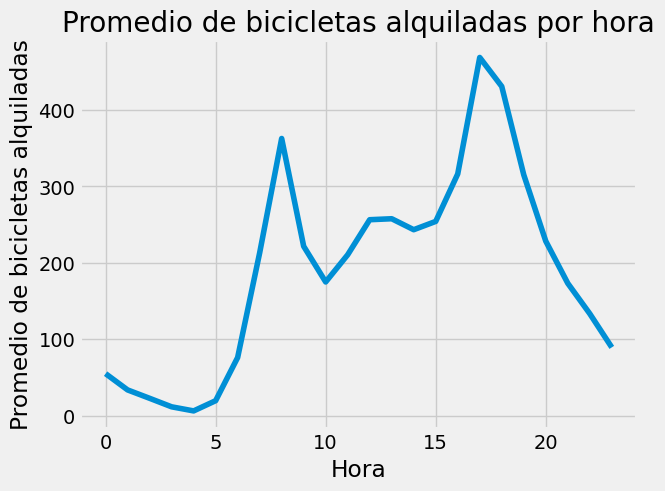

In [13]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

plt.xlabel('Hora')
plt.ylabel('Promedio de bicicletas alquiladas')
plt.title('Promedio de bicicletas alquiladas por hora')
plt.show()

In [14]:
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

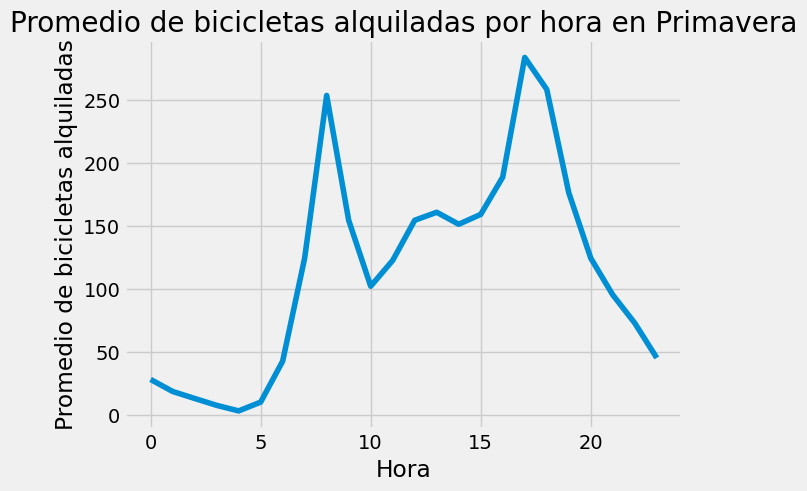

In [15]:
spring = bikes[bikes['season'] == 1]
spring.groupby('hour').total.mean().plot()

plt.xlabel('Hora')
plt.ylabel('Promedio de bicicletas alquiladas')
plt.title('Promedio de bicicletas alquiladas por hora en Primavera')
plt.show()

In [16]:
spring.groupby('hour').total.mean()

hour
0      28.292035
1      18.761062
2      13.205607
3       7.760417
4       3.336634
5      10.300000
6      42.725664
7     124.433628
8     253.345133
9     154.442478
10    102.168142
11    122.601770
12    154.412281
13    160.771930
14    151.263158
15    159.087719
16    188.640351
17    283.456140
18    258.157895
19    176.315789
20    124.394737
21     95.298246
22     72.912281
23     45.333333
Name: total, dtype: float64

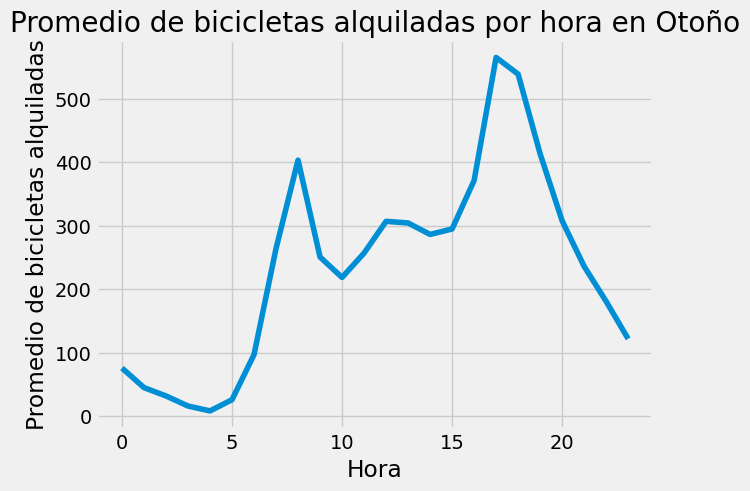

In [17]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
otono = bikes[bikes['season'] == 3]
otono.groupby('hour').total.mean().plot()

plt.xlabel('Hora')
plt.ylabel('Promedio de bicicletas alquiladas')
plt.title('Promedio de bicicletas alquiladas por hora en Otoño')
plt.show()

In [18]:
otono.groupby('hour').total.mean()

hour
0      75.675439
1      44.831858
2      31.707965
3      15.778761
4       8.087719
5      25.728070
6      96.780702
7     264.035088
8     403.508772
9     250.710526
10    218.535088
11    256.877193
12    307.017544
13    304.421053
14    286.350877
15    294.956140
16    371.324561
17    565.385965
18    539.070175
19    413.500000
20    307.842105
21    236.017544
22    180.789474
23    121.719298
Name: total, dtype: float64

**Análisis P2**


Hallazgos gráfica 1 - rentas promedio para cada valor de la variable "hour":
* Se observa que hay dos picos de alta demanda de alquileres que corresponden a las horas 8 de la mañana y 5 de la tarde (17 horas).
* Se observa que el rango de horas con menor alquiler es desde las 0 hasta las 6 horas de la madrugada.

Hallazgos gráfica 2 - rentas promedio para cada valor de la variable "hour" en "season" = 1:
* Se observa que al igual que en la gráfica anterior hay picos de demanda a las 8 de la mañana y a las 5 de la tarde.
* Se observa que a diferencia del primer gráfico, aunque el gráfico parezca similar la escala de promedios de alquiler es menor, es decir, hay menos alquileres promedio en la temporada de primavera que durante todo el año.

Hallazgos gráfica 3 - rentas promedio para cada valor de la variable "hour" en "season" = 3:
* Se observa que al igual que en las gráficas anteriores hay picos de demanda a las 8 de la mañana y a las 5 de la tarde.
* Se observa que también hay una diferencia en la escala de promedio siendo muy superior, por lo cuál podríamos concluir que hay más alquileres promedio en la temporada de otoño que en la temporada de primavera y que en el promedio de todo el año.

En general:
* En las diferentes temporadas se encuentran diferentes promedios, es decir, hay mejores temporadas que otras en términos de alquiler de bicicletas promedio.
* Las horas tienen un impacto similar en la distribución de los alquileres durante el día en las diferentes temporadas de manera proporcional a la cantidad de bicicletas promedio alquiladas en cada temporada.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

**Criterio de evaluación:**
Ajusta un modelo de regresión lineal, considerando las variables "hour" y "season" e interpreta los coeficientes de la regresión. En la regresión, tiene en cuenta que la variable "season" es categórica. Además, describe las limitaciones del modelo considerando las particularidades del problema. [5 puntos]

In [19]:
# Celda 3

# Tratamiento de la variable season como categórica.
orig_data['season']= orig_data['season'].astype(str)
data = orig_data[["season", "hour", "total"]]
season_d = pd.get_dummies(data['season'])
data = pd.concat([data, season_d], axis=1)

del data['season']

# Ajuste modelo de regresión lineal considerando las variables "hour" y "season" 
X = data[['hour','1','2','3','4']]
y = data['total']
X = sm.add_constant(X)
modelo_rl = sm.OLS(y,X).fit()

# Ver coeficientes y resultado entrenamiento
print(modelo_rl.summary())

                            OLS Regression Results                            
Dep. Variable:                  total   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     782.5
Date:                Sun, 02 Apr 2023   Prob (F-statistic):               0.00
Time:                        21:20:43   Log-Likelihood:                -70669.
No. Observations:               10886   AIC:                         1.413e+05
Df Residuals:                   10881   BIC:                         1.414e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         55.6294      2.382     23.354      0.0

**Interpretacón de coeficientes**

* El intercepto de 55.6294, lo cual indica que cuando "season" y "hour" son iguales a cero, el valor esperado de "total" es de 29.53.
* El coeficiente de la temporada de primavera (1 - spring) es de -62.0596, lo que significa que un aumento de una unidad en la variable primavera (por ejemplo, un cambio de invierno a primavera) se asocia con un aumento de 26.95 bicicletas alquiladas.

* La constante o intercepto (55.6294): Este coeficiente representa el valor de la variable de respuesta cuando todas las variables predictoras son cero. En este caso, significa que si todas las variables predictoras (incluyendo la variable categórica) son iguales a cero, el valor esperado de la variable de respuesta es de 55.6294.

* La variable "hour" (10.5452): Este coeficiente representa la relación entre la variable de respuesta y la variable continua "hour". En particular, indica que un aumento de una unidad en "hour" se relaciona con un aumento de 10.5452 unidades en el valor esperado de la variable de respuesta, manteniendo todas las otras variables predictoras constantes.

* La variable "1" correspondiente a la temporada de primavera o spring (-62.0596): Este coeficiente representa la relación entre la variable de respuesta y la categoría correspondiente a la variable categórica codificada por "1". En particular, indica que si la variable categórica toma el valor de "1" o primavera, se espera una disminución de 62.0596 unidades en el valor esperado de la variable de respuesta (total de bicicletas alquiladas), manteniendo todas las otras variables predictoras constantes.

* La variable "2" correspondiente a la temporada de verano o summer (38.2576): Este coeficiente representa la relación entre la variable de respuesta y la categoría correspondiente a la variable categórica codificada por "2". En particular, indica que si la variable categórica toma el valor de "2" o verano, se espera un aumento de 38.2576 unidades en el valor esperado de la variable de respuesta (total de bicicletas alquiladas), manteniendo todas las otras variables predictoras constantes.

* La variable "3" correspondiente a la temporada de otoño o fall (57.4079): Este coeficiente representa la relación entre la variable de respuesta y la categoría correspondiente a la variable categórica codificada por "3". En particular, indica que si la variable categórica toma el valor "3" u otoño, se espera un aumento de 57.4079 unidades en el valor esperado de la variable de respuesta (total de bicicletas alquiladas), manteniendo todas las otras variables predictoras constantes.

* La variable "4" correspondiente a la temporada de invierno o winter (22.0235): Este coeficiente representa la relación entre la variable de respuesta y la categoría correspondiente a la variable categórica codificada por "4". En particular, indica que si la variable categórica toma el valor de "4" o invierno, se espera un aumento de 22.0235 unidades en el valor esperado de la variable de respuesta (total de bicicletas alquiladas), manteniendo todas las otras variables predictoras constantes.

* Se observa que aunque las variables son significativas, el r cuadrado es de 0.223 lo cuál indica que el modelo no lográ representar la relación entre el alquiler de bicicletas de acuerdo con la temporada y la hora del día.

**Evaluación de limitaciones de la implementación por las particularidades del problema**

En primer lugar al usar un modelo de relación lineal entre las variables predictoras y la variable objetivo, se está asumiendo que hay una relación linal entre estas pero no necesariamente es así. También se descartaron muchas variables que podrían tener algo que ver con el número de bicicletas rentadas, como humedad, velocidad del viento, temperatura, dia de la semana, entre otras. 

Dado lo anterior, el modelo fue calibrado sin tener en consideración todas las perspectivas del problema.



### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

**Criterio de evaluación:**
El algoritmo utilizado sigue la lógica correcta para la creación manual de un árbol de decisión. El resultado obtenido itera sobre las variables "hour" y "season" y tiene al menos seis nodos. [5 puntos]

In [20]:
# Celda 4

# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)
    
# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    return gini_impurity_

# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):    
    features = range(X.shape[1])
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)        
            if gain > best_split[2]:
                best_split = [j, split, gain]    
    return best_split


# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=None):
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree


def tree_predict(X, tree, proba=False):
    predicted = np.ones(X.shape[0])
    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']  
    else:
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]
        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
    return predicted

In [21]:
# Entrenamiento y ajuste del arbol
tree = tree_grow(X, y, level=0, min_gain=0.001, max_depth=6, num_pct=10)
y_pred = tree_predict(X, tree)
y_true = y

In [22]:
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("MSE: {:.2f}, R2: {:.2f}".format(mse, r2))

MSE: 69128.80, R2: -1.11


**Análisis P4:**
* Se entrenó un árbol ´manualmente con los siguientes parámetros: level=0, min_gain=0.001, max_depth=12, num_pct=10.
* Este árbol obtuvo un MSE de 69128 y un R2 de -1.11 que indica que el modelo no se ajusta bien a los datos y que su error es mayor que el de una predicción ingenua. En otras palabras sugiere que el modelo no es adecuado para los datos y que es necesario revisar el modelo y/o los datos para identificar y corregir cualquier problema que pueda existir.

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

**Criterio de evaluación:**
Hace uso de la librería de sklearn para implementar un árbol de decisión; considera las variables "hour" y "season" y realiza la calibración de los parámetros del modelo. Además, usa alguna métrica de desempeño de modelos de clasificación para analizar el compartimiento del árbol obtenido en comparación al desempeño del modelo del punto 3. [5 puntos]

Text(0, 0.5, 'Accuracy')

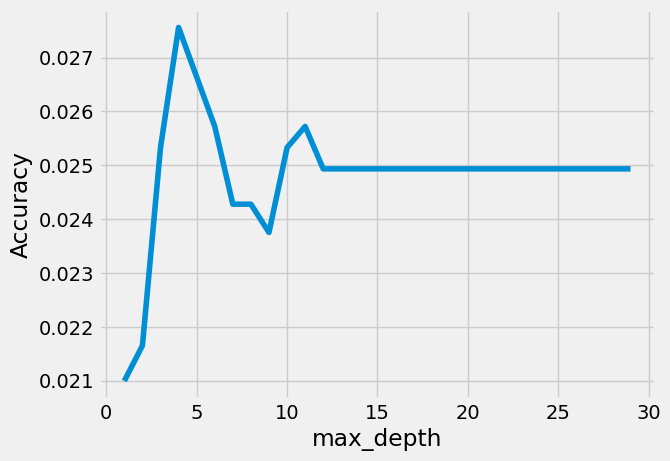

In [23]:
# Celda 5
#División de los datos en muestras de entrenamiento y validación:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 30)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())
    

# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [24]:
# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.027559055118110232, 4)

In [25]:
# max_depth=4 fue el mejor, se ajusta un árbol usando este valor 
clf = DecisionTreeClassifier(max_depth=4, random_state=1)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=1)

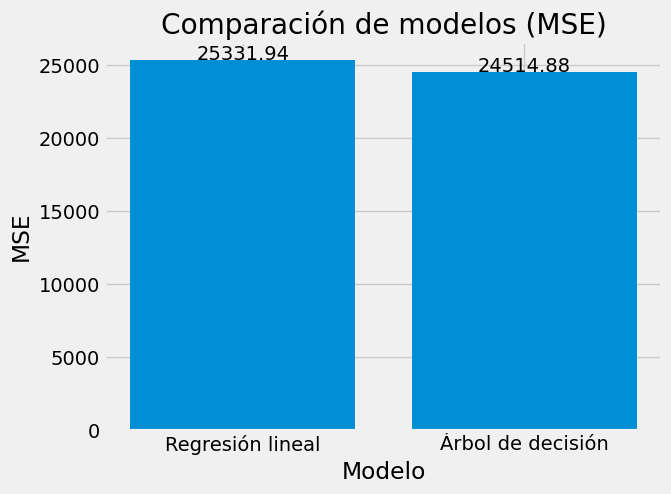

In [26]:
modelo_rl = LinearRegression()
modelo_rl.fit(X_train, y_train)

y_pred_rl = modelo_rl.predict(X_test)
y_pred_cls = clf.predict(X_test)

mse_rl = mean_squared_error(y_test, y_pred_rl)
mse_tree = mean_squared_error(y_test, y_pred_cls)
mse_values = [mse_rl, mse_tree]

model_names = ['Regresión lineal', 'Árbol de decisión']

for i, v in enumerate(mse_values):
    plt.text(i, v, str(round(v,2)), ha='center')
    
plt.bar(model_names, mse_values)
plt.title('Comparación de modelos (MSE)')
plt.xlabel('Modelo')
plt.ylabel('MSE')
    
plt.show()

**Análisis P5:**

El modelo de árbol de decisión tiene mejor desempeño que el de regresión lineal al compararse usando la métrica MEAN SQUARED ERROR o MSE.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [27]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [28]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [29]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

**Criterio de evaluación:**
Construye una regresión logística y un árbol de decisión usando correctamente la librería de sklearn. El árbol lo calibra con al menos un parámetro y compara satisfactoriamente los desempeños de los modelos con el Accuracy y el F1-Score. [5 puntos]    

In [30]:
# Celda 6

# Calibrar Arbol de decisión:

max_depth_range = range(1, 30)

accuracy_scores = []

for depth in max_depth_range:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())
    
best_depth_calibrated = sorted(zip(accuracy_scores, max_depth_range))[::-1][0][1]

clf = DecisionTreeClassifier(max_depth=best_depth_calibrated, random_state=1)
clf.fit(X_train, y_train)

tree_pred = clf.predict(X_test)

tree_acc = accuracy_score(y_test, tree_pred)
tree_f1 = f1_score(y_test, tree_pred, average='binary')

# Calibrar Regresión logistica:

logrm = LogisticRegression(random_state=1)
logrm.fit(X_train, y_train)
logrm_pred = logrm.predict(X_test)

logrm_acc = accuracy_score(y_test, logrm_pred)
logrm_f1 = f1_score(y_test, logrm_pred, average='binary')

# Consolidar resultados:
rows = ['F1-Score', 'Accuracy']

data = {
            'Regresión Lógistica': [logrm_f1, logrm_acc],
            'Árbol de Decisión': [tree_f1, tree_acc]
        }

pd.DataFrame(data, index=rows)

,Regresión Lógistica,Árbol de Decisión
F1-Score,0.610215,0.644860
Accuracy,0.613333,0.645333


**Análisis P6:**

En la tabla anterior se observa el desempeño de un modelo de arbol de decisión calibrando el parámetro de profundidad y uno de regresión logistica. Comparando sus métricas F1-Score y Accuracy se puede notar que en ambos casos, el arbol presenta un mejor desempeño.

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth tome un valor de su elección\
-100 árboles de decisión donde min_samples_leaf tome un valor de su elección\
-100 regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

**Criterio de evaluación:**
Construye correctamente un modelo de ensamble con la metodología de votación mayoritaria con 300 muestras bagged para tres escenarios: 100 árboles de decisión donde el parámetro max_depth toma un valor elegido, 100 árboles de decisión donde el parámetro min_samples_leaf toma un valor elegido y 100 regresiones logísticas. Además, compara el desempeño de los modelos con el Accuracy y F1-score. [5 puntos]

In [31]:
# Celda 7
# Escenario 1 donde max_depth tome un valor de su elección
clf_md = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5, random_state=1), n_estimators=100,
                           bootstrap=True, random_state=42, n_jobs=-1, oob_score=True)


# Escenario 2 donde min_samples_leaf tome un valor de su elección
clf_msl = BaggingClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf=4, random_state=1), n_estimators=100,
                            bootstrap=True, random_state=42, n_jobs=-1, oob_score=True)

# Escenario 3 regresiones logísticas
clf_reglog = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100,
                               bootstrap=True, random_state=42, n_jobs=-1, oob_score=True)

# Ensamble de los 3 modelos
ensemble = VotingClassifier(estimators=[('tree1', clf_md), ('tree2', clf_msl), ('logreg', clf_reglog)], voting='hard')

# Entrenar todos los modelos por separado y el ensamble.
models = [clf_md, clf_msl, clf_reglog, ensemble]
accs = []
f1s = []
titles = ['Tree with max_depth = 5', 'Tree with min_samples_leaf=4', '100 Logistic Regressions', 'Ensemble of three models']

for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1, acc = metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)
    accs.append(acc)
    f1s.append(f1)
    
# Consolidar resultados:
rows = ['F1-Score', 'Accuracy']
data = {}

for i in range(len(models)):
    data[titles[i]] = [accs[i], f1s[i]]

pd.DataFrame(data, index=rows)

,Tree with max_depth = 5,Tree with min_samples_leaf=4,100 Logistic Regressions,Ensemble of three models
F1-Score,0.657333,0.654667,0.616667,0.652667
Accuracy,0.657333,0.656499,0.611749,0.653821


**Análisis P7:**

En la tabla anterior se observa el desempeño de los 3 escenarios descritos en el enunciado y uno que ensambla los 3 anteriores. Comparando sus métricas F1-Score y Accuracy se puede notar que en ambos casos, el escenario presenta un mejor desempeño es el del árbol con profundidad máxima 5, seguido del árbol con minimo 4 muestras por hoja y finalmente tenemos al modelo de ensamble por votación mayoritaria y las 100 regresiones lógisticas.

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

**Criterio de evaluación:**
Construye correctamente un modelo de ensamble con la metodología de votación ponderada con 300 muestras bagged para tres escenarios: 100 árboles de decisión donde el parámetro max_depth toma un valor elegido, 100 árboles de decisión donde el parámetro min_samples_leaf toma un valor elegido y 100 regresiones logísticas. Además, compara el desempeño de los modelos con el Accuracy y F1-score. [5 puntos]





In [32]:
# Celda 8

# Escenario 1 donde max_depth tome un valor de su elección
clf_md_2 = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5, random_state=1), n_estimators=100,
                           bootstrap=True, random_state=42, n_jobs=-1, oob_score=True)

# Escenario 2 donde min_samples_leaf tome un valor de su elección
clf_msl_2 = BaggingClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf=4, random_state=1), n_estimators=100,
                            bootstrap=True, random_state=42, n_jobs=-1, oob_score=True)

# Escenario 3 regresiones logísticas
clf_reglog_2 = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100,
                               bootstrap=True, random_state=42, n_jobs=-1, oob_score=True)

# Ensamble de los 3 modelos
weights = [0.5, 0.3, 0.2] 
ensemble_2 = VotingClassifier(estimators=[('tree1', clf_md), ('tree2', clf_msl), ('logreg', clf_reglog)], voting='soft', weights = weights)

# Entrenar todos los modelos por separado y el ensamble.
models2 = [clf_md_2, clf_msl_2, clf_reglog_2, ensemble_2]
accs2 = []
f1s2 = []
titles2 = ['Tree with max_depth = 5', 'Tree with min_samples_leaf=4', '100 Logistic Regressions', 'Ensemble of three models']

for model in models2:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    if type(model) != VotingClassifier:
        # Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
        errors = np.zeros(model.n_estimators)
        y_pred_all_ = np.zeros((X_test.shape[0], model.n_estimators))

        for i in range(model.n_estimators):
            oob_sample = ~model.estimators_samples_[i]
            y_pred_ = model.estimators_[i].predict(X_train.values[oob_sample])
            errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
            y_pred_all_[:, i] = model.estimators_[i].predict(X_test)
            
        alpha = (1 - errors) / (1 - errors).sum()
        y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

    # Desempeño al hacer votación ponderada
    f1, acc = metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)
    
    accs2.append(acc)
    f1s2.append(f1)
    
# Consolidar resultados:
rows2 = ['F1-Score', 'Accuracy']
data2 = {}

for i in range(len(models)):
    data2[titles2[i]] = [accs2[i], f1s2[i]]

pd.DataFrame(data2, index=rows2)

,Tree with max_depth = 5,Tree with min_samples_leaf=4,100 Logistic Regressions,Ensemble of three models
F1-Score,0.655333,0.647333,0.621333,0.657333
Accuracy,0.649492,0.634921,0.617766,0.657333


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

**Criterio de evaluación:**
Compara los resultados de desempeño obtenidos con las dos metodologías implementadas en los puntos 7 y 8, y enuncia las ventajas o desventajas de cada metodología. [5 puntos]

**Comparación y análisis de resultados:**

* Se evidencia que la estrategia de votación ponderada para el ensamblaje de los 3 modelos, entregó mejores resultados que la estrategia de votación mayoritaria, eso puede deberse a que se consideró un mayor peso en el modelo que mejor resultados individuales tuvo que fue el del escenario número 1 entre otros factores.
* Se resalta que el accuracy y el f1-score obtenidos por los 2 de los 3 modelos entrenados bajo escenarios del enunciado en la metodología de votación ponderada son menores a los obtenidos por la metodologia de votación mayoritaria.

* En cuanto a las posibles ventajas de la votación ponderada, esta técnica puede mejorar la precisión del modelo al permitir que los clasificadores más precisos tengan un mayor impacto en la predicción final. Además, puede ser útil en situaciones en las que algunos clasificadores son inherentemente más precisos que otros, por lo que es importante tener en cuenta sus diferencias en la votación.

* Por otro lado, las posibles desventajas de la votación ponderada incluyen la necesidad de calibrar los pesos de los clasificadores, lo que puede requerir tiempo y esfuerzo adicional. También puede ser susceptible a sobreajuste si se asignan pesos incorrectos a los clasificadores.

* En cuanto a la votación mayoritaria, una ventaja potencial es su simplicidad y facilidad de implementación. Además, puede ser más resistente al ruido y a los errores de clasificación individuales, ya que el resultado final se basa en la mayoría de los clasificadores y no en uno en particular.

* Sin embargo, una desventaja posible de la votación mayoritaria es que no tiene en cuenta la precisión relativa de los clasificadores individuales, lo que puede ser problemático en situaciones en las que algunos clasificadores son mucho más precisos que otros. También puede tener un rendimiento inferior en comparación con la votación ponderada en situaciones donde los clasificadores tienen una precisión muy desigual.

En conclusion, la elección entre votación ponderada y votación mayoritaria depende de las características específicas del conjunto de datos, los clasificadores utilizados y el contexto del problema que se está abordando. Ambas técnicas tienen ventajas y desventajas que deben considerarse cuidadosamente antes de tomar una decisión.